## IMPORT DATASET 

In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("upload_data").getOrCreate()


df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)



In [2]:

df.show()

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Spark session start
spark = SparkSession.builder.appName("AddHeaderToDataFrame").getOrCreate()

columns = ["number", "id", "date", "query", "username", "text"]



# Header row
header = ("number", "id", "date", "query", "username", "text")

# Adding header row
df = df.toDF(*header)


df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|        id|                date|   query|       username|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_

In [4]:

df.printSchema()



root
 |-- number: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
drop_cols= ("id","query","username")
df = df.drop(*drop_cols)

In [6]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1600000 rows and  3 columns in the dataset.


In [7]:
# Missing values check

from pyspark.sql import functions as func

df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,number,date,text
0,0,0,0


In [8]:
# Duplicates check

df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1600000


In [9]:
#  Column types

df.dtypes


[('number', 'int'), ('date', 'string'), ('text', 'string')]

In [10]:
df.printSchema()


root
 |-- number: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)



In [11]:
df.show(5, truncate = False)

+------+----------------------------+--------------------------------------------------------------------------------------------+
|number|date                        |text                                                                                        |
+------+----------------------------+--------------------------------------------------------------------------------------------+
|146   |Mon Apr 06 22:28:26 PDT 2009|my nokia 1110 died..                                                                        |
|851   |Mon Apr 06 23:18:02 PDT 2009|@stewiebrittany no  i dont even know how to ride it                                         |
|1436  |Tue Apr 07 00:01:00 PDT 2009|@CyFyre no   finished two years then had twinzzzzzzzzzzz                                    |
|1508  |Tue Apr 07 00:05:37 PDT 2009|Oh dear, all the pups died 1 by 1 last night, perhaps it was because Princess rejected them |
|1756  |Tue Apr 07 00:23:59 PDT 2009|Somewhere in the world right now the sun is sh

## CLEAN TEXT

In [12]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [13]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TOKENIZATION

In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
from pyspark.sql.types import StringType,FloatType

%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.62 µs


In [17]:
df.show()


+------+--------------------+--------------------+--------------------+
|number|                date|                text|        text_cleaned|
+------+--------------------+--------------------+--------------------+
|   146|Mon Apr 06 22:28:...|my nokia 1110 die...|     nokia 1110 died|
|   851|Mon Apr 06 23:18:...|@stewiebrittany n...| dont even know ride|
|  1436|Tue Apr 07 00:01:...|@CyFyre no   fini...|finished two year...|
|  1508|Tue Apr 07 00:05:...|Oh dear, all the ...|oh dear pups died...|
|  1756|Tue Apr 07 00:23:...|Somewhere in the ...|somewhere world r...|
|  1760|Tue Apr 07 00:24:...|Goodnight everyon...|goodnight everyon...|
|  1777|Tue Apr 07 00:25:...|oh em gee. this i...|oh em gee love wa...|
|  1817|Tue Apr 07 00:29:...|trying to write d...|trying write dsse...|
|  2015|Tue Apr 07 00:45:...| there is no way ...|way go school tod...|
|  2063|Tue Apr 07 00:48:...|@Cuckolds I'm bei...|set except watch ...|
|  2239|Tue Apr 07 01:02:...|Borning - thats m...|borning thats 

In [18]:
df = df.drop("text")


In [19]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

window_spec = Window.orderBy("date")

df = df.withColumn("row_number", F.row_number().over(window_spec))

df.show()


2023-11-15 15:40:30,442 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+
|number|                date|        text_cleaned|row_number|
+------+--------------------+--------------------+----------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|
|  8580|Fri Apr 17 20:30:...|aww r cutest thin...|         6|
|  8582|Fri Apr 17 20:30:...|boyfriend going t...|         7|
|  8581|Fri Apr 17 20:30:...|sweet josh work t...|         8|
|  8585|Fri Apr 17 20:30:...|sorry loss honey ...|         9|
|  8584|Fri Apr 17 20:30:...|losing followers lol|        10|
|  8586|Fri Apr 17 20:30:...|               tired|        11|
|  8583|Fri Apr 17 20:30:...|sim see tonight e...|        12|
|  8588|Fri Apr 17 20:30:...|misses updating c...|        13|
|  8587|

## SENTIMENT ANALYSIS

In [20]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from textblob import TextBlob


#  UDF (User-Defined Function) 
schema = StructType([StructField("polarity", FloatType(), True), StructField("subjectivity", FloatType(), True)])

def calc_sentiment_udf(txt):
    blob = TextBlob(txt)
    return (blob.sentiment.polarity, blob.sentiment.subjectivity)

sentiment_udf = udf(calc_sentiment_udf, schema)

df = df.withColumn("sentiment", sentiment_udf(df["text_cleaned"]))

df = df.withColumn("polarity", df["sentiment.polarity"])
df = df.withColumn("subjectivity", df["sentiment.subjectivity"])

df.sample(withReplacement=False, fraction=0.1).show()


2023-11-15 15:41:31,599 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+-----------+------------+
|number|                date|        text_cleaned|row_number|           sentiment|   polarity|subjectivity|
+------+--------------------+--------------------+----------+--------------------+-----------+------------+
|  8591|Fri Apr 17 20:30:...|andi sweetheart r...|        15|{0.13333334, 0.83...| 0.13333334|   0.8333333|
|  8606|Fri Apr 17 20:31:...|course excited pi...|        32|     {0.5875, 0.725}|     0.5875|       0.725|
|  8609|Fri Apr 17 20:31:...|close friend one ...|        36|{0.009375, 0.384375}|   0.009375|    0.384375|
|  8617|Fri Apr 17 20:31:...|ohhh saying face ...|        41|          {0.0, 0.0}|        0.0|         0.0|
|  8619|Fri Apr 17 20:31:...|got home kind lat...|        45|{0.083333336, 0.6...|0.083333336|   0.6333333|
|  8620|Fri Apr 17 20:31:...|unfortunately thi...|        46| {-0.18333334, 0.55}|-0.18333334|        0.55|
|  8633|Fri Apr 17 20:32:...

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

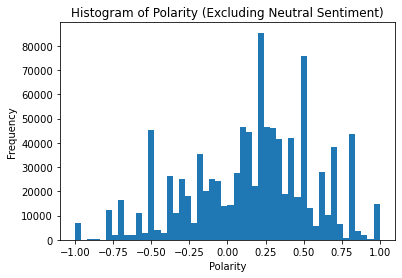

In [22]:
processed_data = df.filter(df["polarity"] != 0.0).select("polarity").toPandas()

plt.hist(processed_data["polarity"], bins=50)
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Histogram of Polarity (Excluding Neutral Sentiment)")
plt.show()

In [23]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


from pyspark.sql.functions import to_timestamp

timestamp = to_timestamp("Mon Nov 05 20:40:00 2023 PST", "EEE MMM dd HH:mm:ss yyyy Z")


In [24]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType



# Convert the date column to a Timestamp type.
df = df.withColumn("new_date", F.to_timestamp(df["date"], "EEE MMM dd HH:mm:ss z yyyy"))

# Cast the new_date column to a TimestampType.
df = df.withColumn("new_date", F.col("new_date").cast(TimestampType()))

# Display the DataFrame.
df.show()


2023-11-15 15:44:32,238 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|number|                date|        text_cleaned|row_number|           sentiment|   polarity|subjectivity|           new_date|
+------+--------------------+--------------------+----------+--------------------+-----------+------------+-------------------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|{-0.24583334, 0.5...|-0.24583334|   0.5708333|2009-04-18 04:30:31|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|          {0.0, 0.0}|        0.0|         0.0|2009-04-18 04:30:34|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|         {-0.3, 0.4}|       -0.3|         0.4|2009-04-18 04:30:38|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|{-0.5515873, 0.84...| -0.5515873|   0.8452381|2009-04-18 04:30:39|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|{-0.125, 0.41666666}|     -0.125|  0.416666

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

# SparkSession oluştur
spark = SparkSession.builder.appName("TwitterDataProcessing").getOrCreate()


# 'new_date' sütununu tarih formatına çevir
df = df.withColumn("time", col("new_date").cast(TimestampType()))

# Gereksiz sütunları çıkar
df = df.select("number", "time", "polarity")

# 'new_date' sütununu çıkar
df = df.drop("new_date")

# 'time' sütununa göre sırala
df = df.orderBy("time")

# Sonuçları göster
df.show(truncate=False)


+------+-------------------+-----------+
|number|time               |polarity   |
+------+-------------------+-----------+
|0     |2009-04-07 06:19:45|0.2        |
|1     |2009-04-07 06:19:49|0.0        |
|2     |2009-04-07 06:19:53|0.5        |
|4     |2009-04-07 06:19:57|-0.625     |
|3     |2009-04-07 06:19:57|0.2        |
|5     |2009-04-07 06:20:00|0.2        |
|7     |2009-04-07 06:20:03|0.34166667 |
|6     |2009-04-07 06:20:03|0.0        |
|8     |2009-04-07 06:20:05|0.0        |
|9     |2009-04-07 06:20:09|0.0        |
|10    |2009-04-07 06:20:16|-0.21428572|
|11    |2009-04-07 06:20:17|0.0        |
|12    |2009-04-07 06:20:19|0.0        |
|13    |2009-04-07 06:20:19|0.0        |
|14    |2009-04-07 06:20:20|0.225      |
|15    |2009-04-07 06:20:20|0.0        |
|16    |2009-04-07 06:20:22|0.0        |
|17    |2009-04-07 06:20:25|0.0        |
|18    |2009-04-07 06:20:31|0.5        |
|19    |2009-04-07 06:20:34|0.0        |
+------+-------------------+-----------+
only showing top

## WEEKLY STATS

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, weekofyear, max, min, mean, stddev

# Spark session oluşturun
spark = SparkSession.builder.appName("WeeklyPolarityStatistics").getOrCreate()


# "time" sütununu tarih ve hafta numarasına çevirin
df = df.withColumn("time", col("time").cast("timestamp"))
df = df.withColumn("week", weekofyear("time"))

# Haftalık istatistikleri alın
weekly_stats = df.groupBy("week").agg(
    mean("polarity").alias("avg_polarity"),
    stddev("polarity").alias("stddev_polarity"),
    min("polarity").alias("min_polarity"),
    max("polarity").alias("max_polarity")
)

# İstatistikleri göster
weekly_stats.show()


+----+--------------------+-------------------+------------+------------+
|week|        avg_polarity|    stddev_polarity|min_polarity|max_polarity|
+----+--------------------+-------------------+------------+------------+
|  26|-0.01394785479974...|0.32733840598700026|        -1.0|         1.0|
|  22| 0.12566666412672822|0.33263216488193675|        -1.0|         1.0|
|  16|  0.1198705260658071|0.33030722741464014|        -1.0|         1.0|
|  20| 0.12063526645990055|0.33335135723342824|        -1.0|         1.0|
|  19| 0.13571751746660493| 0.3491667109771893|        -1.0|         1.0|
|  15| 0.10502953406290622| 0.3334875376553309|        -1.0|         1.0|
|  17| 0.11721694645543472| 0.3314418122749561|        -1.0|         1.0|
|  23| 0.11730814922956001| 0.3319286929353154|        -1.0|         1.0|
|  25| 0.04095277050689163| 0.3323633410348467|        -1.0|         1.0|
|  24| 0.11503489054103769|0.33546076286680665|        -1.0|         1.0|
|  21|  0.1277597873514982|0.332743321

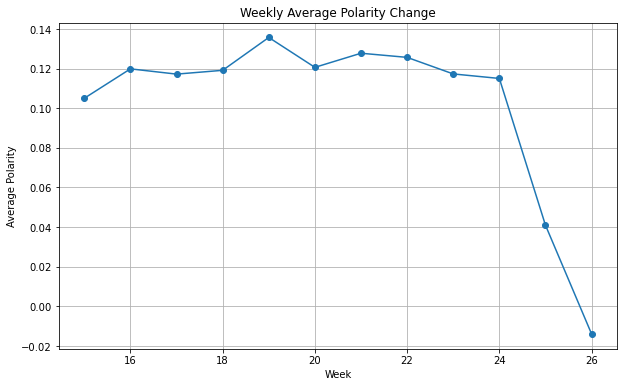

In [29]:
import matplotlib.pyplot as plt

# Spark DataFrame'i week sütununa göre sırala
sorted_weekly_stats = weekly_stats.orderBy("week")

# Pandas DataFrame'e çevirme
pandas_weekly_stats = sorted_weekly_stats.toPandas()

# Grafiği çizme
plt.figure(figsize=(10, 6))
plt.plot(pandas_weekly_stats['week'], pandas_weekly_stats['avg_polarity'], marker='o', linestyle='-')
plt.title('Weekly Average Polarity Change')
plt.xlabel('Week')
plt.ylabel('Average Polarity')
plt.grid(True)
plt.show()


##  TIME SERIES 

In [35]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()


df = df.withColumn("time", col("time").cast("timestamp"))

# 1 week time series
weekly_series = df.groupBy(window("time", "1 week")).count()
weekly_series.show(truncate=False)

# 1 month time series 
monthly_series = df.groupBy(window("time", "30 days")).count()
monthly_series.show(truncate=False)

# 3 months time series
quarterly_series = df.groupBy(window("time", "90 days")).count()
quarterly_series.show(truncate=False)


spark.stop()


+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{2009-05-21 01:00:00, 2009-05-28 01:00:00}|53163 |
|{2009-04-02 01:00:00, 2009-04-09 01:00:00}|20671 |
|{2009-06-25 01:00:00, 2009-07-02 01:00:00}|25993 |
|{2009-04-30 01:00:00, 2009-05-07 01:00:00}|85964 |
|{2009-06-18 01:00:00, 2009-06-25 01:00:00}|191556|
|{2009-05-14 01:00:00, 2009-05-21 01:00:00}|107295|
|{2009-05-07 01:00:00, 2009-05-14 01:00:00}|41954 |
|{2009-05-28 01:00:00, 2009-06-04 01:00:00}|504061|
|{2009-06-04 01:00:00, 2009-06-11 01:00:00}|274625|
|{2009-04-16 01:00:00, 2009-04-23 01:00:00}|79354 |
|{2009-06-11 01:00:00, 2009-06-18 01:00:00}|215364|
+------------------------------------------+------+



+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{2009-06-05 01:00:00, 2009-07-05 01:00:00}|702900|
|{2009-04-06 01:00:00, 2009-05-06 01:00:00}|185989|
|{2009-05-06 01:00:00, 2009-06-05 01:00:00}|711111|
+------------------------------------------+------+



+------------------------------------------+------+
|window                                    |count |
+------------------------------------------+------+
|{2009-06-05 01:00:00, 2009-09-03 01:00:00}|702900|
|{2009-03-07 00:00:00, 2009-06-05 01:00:00}|897100|
+------------------------------------------+------+



## WEEKLY FORECAST

/tmp/ipykernel_19761/2654687068.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
/home/hduser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


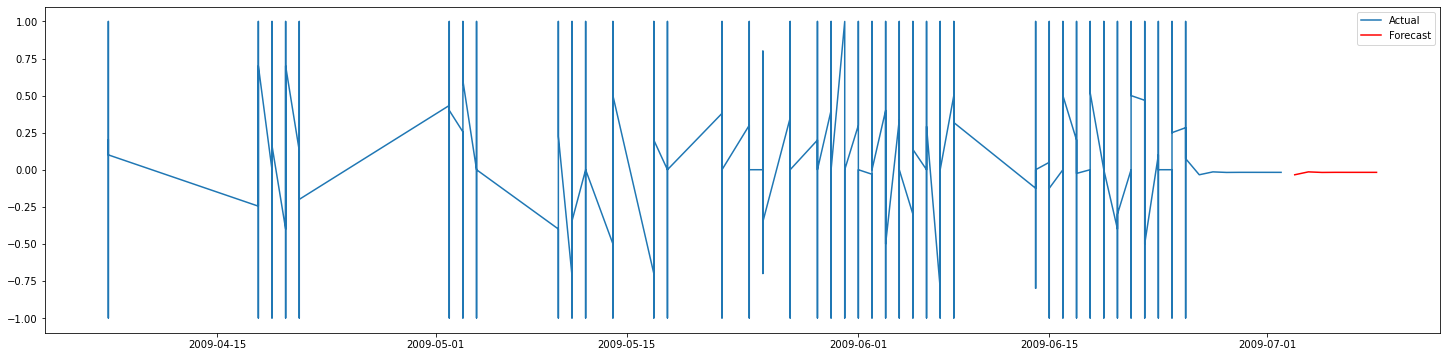

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

# PySpark Session oluştur
spark = SparkSession.builder.appName("ARIMA_Example").getOrCreate()

# 'time' sütununu tarih formatına dönüştür
df_spark = df.withColumn("time", col("time").cast("date"))

# Haftalık gruplama ve ortalama alma işlemleri
window_spec = Window.orderBy("time").rowsBetween(-float('inf'), 0)
df_spark = df_spark.withColumn("weekly_avg_polarity", col("polarity"))
df_spark = df_spark.withColumn("weekly_avg_polarity", col("weekly_avg_polarity").cast("double"))

# ARIMA modelini oluştur
model = ARIMA(df_spark.select("weekly_avg_polarity").toPandas(), order=(2, 1, 1))  # (p, d, q) değerlerini istediğiniz gibi ayarlayabilirsiniz
results = model.fit()

# Gelecek 7 gün için tahmin yap
forecast_steps = 7
forecast = results.get_forecast(steps=forecast_steps)

# Tahmin edilen değerler ve güven aralıklarını al
forecast_values = forecast.predicted_mean

# Önceki verileri ve tahminleri birleştir
df_forecast = df_spark.toPandas()
df_forecast = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
                                                "weekly_avg_polarity": forecast_values}))

# Tahmin edilen değerleri ve güven aralıklarını görselleştir
plt.figure(figsize=(25, 6)) 
plt.plot(df_forecast['time'], df_forecast['weekly_avg_polarity'], label='Actual')
plt.plot(pd.date_range(start=df_forecast['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast_values, color='red', label='Forecast')
plt.legend()
plt.show()


# Without Zero Polarity

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_19761/300061979.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast0 = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast0['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
/home/hduser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match th

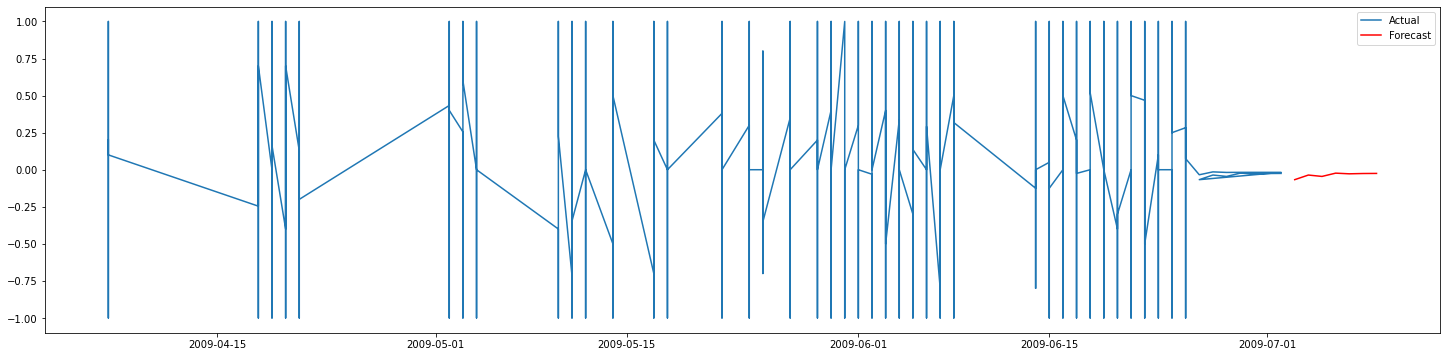

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

# PySpark Session oluştur
spark = SparkSession.builder.appName("ARIMA_Example").getOrCreate()

# 'time' sütununu tarih formatına dönüştür
df_spark = df.withColumn("time", col("time").cast("date"))

# Haftalık gruplama ve ortalama alma işlemleri
window_spec = Window.orderBy("time").rowsBetween(-float('inf'), 0)
df_spark = df_spark.withColumn("weekly_avg_polarity", col("polarity"))
df_spark = df_spark.withColumn("weekly_avg_polarity", col("weekly_avg_polarity").cast("double"))

# 0 olan satırları filtrele
df_spark = df_spark.filter(col("polarity") != 0)

# ARIMA modelini oluştur
model = ARIMA(df_spark.select("weekly_avg_polarity").toPandas(), order=(4, 1, 1))  # (p, d, q) değerlerini istediğiniz gibi ayarlayabilirsiniz
results = model.fit()

# Gelecek 7 gün için tahmin yap
forecast_steps = 7
forecast = results.get_forecast(steps=forecast_steps)

# Tahmin edilen değerler ve güven aralıklarını al
forecast_values = forecast.predicted_mean

# Önceki verileri ve tahminleri birleştir
df_forecast0 = df_spark.toPandas()
df_forecast0 = df_forecast.append(pd.DataFrame({"time": pd.date_range(start=df_forecast0['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
                                                "weekly_avg_polarity": forecast_values}))

# Tahmin edilen değerleri ve güven aralıklarını görselleştir
plt.figure(figsize=(25, 6)) 
plt.plot(df_forecast0['time'], df_forecast0['weekly_avg_polarity'], label='Actual')
plt.plot(pd.date_range(start=df_forecast0['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast_values, color='red', label='Forecast')
plt.legend()
plt.show()


## MONTHLY FORECAST

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipykernel_4436/2511648888.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast30 = df_forecast30.append(pd.DataFrame({"time": pd.date_range(start=df_forecast30['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
/home/hduser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to matc

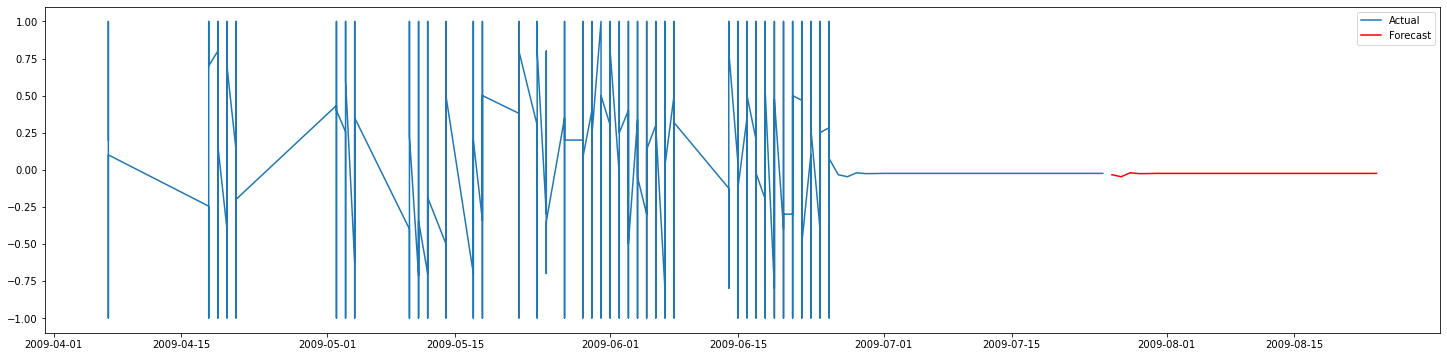

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

# PySpark Session oluştur
spark = SparkSession.builder.appName("ARIMA_Example").getOrCreate()

# 'time' sütununu tarih formatına dönüştür
df_spark = df.withColumn("time", col("time").cast("date"))

# Aylık gruplama ve ortalama alma işlemleri
window_spec = Window.orderBy("time").rowsBetween(-float('inf'), 0)
df_spark = df_spark.withColumn("monthly_avg_polarity", col("polarity"))
df_spark = df_spark.withColumn("monthly_avg_polarity", col("monthly_avg_polarity").cast("double"))

# 0 olan satırları filtrele
df_spark = df_spark.filter(col("polarity") != 0)

# ARIMA modelini oluştur
model = ARIMA(df_spark.select("monthly_avg_polarity").toPandas(), order=(3, 1, 1))  # (p, d, q) değerlerini istediğiniz gibi ayarlayabilirsiniz
results = model.fit()

# Gelecek 30 gün için tahmin yap (bir ay)
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)

# Tahmin edilen değerler ve güven aralıklarını al
forecast_values = forecast.predicted_mean

# Önceki verileri ve tahminleri birleştir
df_forecast30 = df_spark.toPandas()
df_forecast30 = df_forecast30.append(pd.DataFrame({"time": pd.date_range(start=df_forecast30['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
                                                "monthly_avg_polarity": forecast_values}))

# Tahmin edilen değerleri ve güven aralıklarını görselleştir
plt.figure(figsize=(25, 6)) 
plt.plot(df_forecast30['time'], df_forecast30['monthly_avg_polarity'], label='Actual')
plt.plot(pd.date_range(start=df_forecast30['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast_values, color='red', label='Forecast')
plt.legend()
plt.show()

## 3 MONTH FORECAST

/tmp/ipykernel_4436/3713645245.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_forecast90 = df_forecast90.append(pd.DataFrame({"time": pd.date_range(start=df_forecast90['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
/home/hduser/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


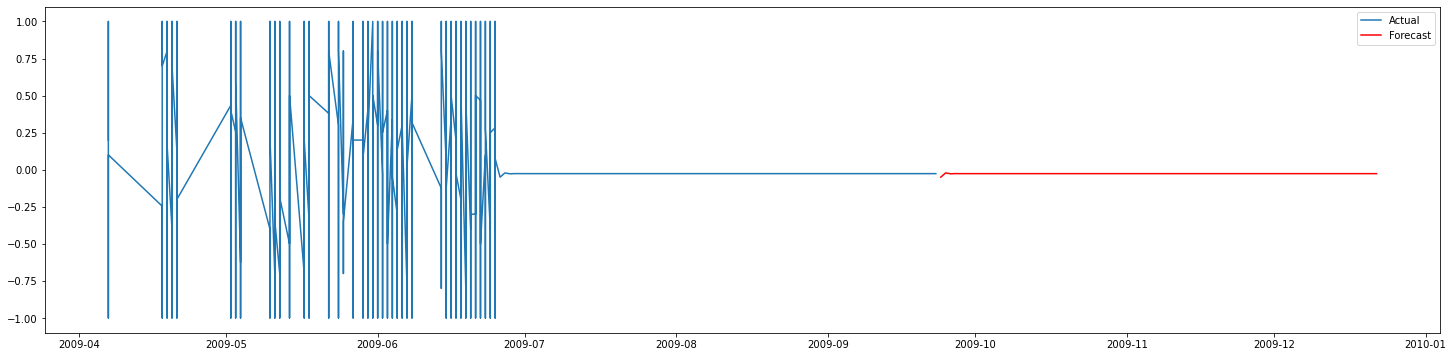

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.window import Window

# PySpark Session oluştur
spark = SparkSession.builder.appName("ARIMA_Example").getOrCreate()

# 'time' sütununu tarih formatına dönüştür
df_spark90 = df.withColumn("time", col("time").cast("date"))

# 3 aylık gruplama ve ortalama alma işlemleri
window_spec = Window.orderBy("time").rowsBetween(-float('inf'), 0)
df_spark90 = df_spark90.withColumn("3months_avg_polarity", col("polarity"))
df_spark90 = df_spark90.withColumn("3months_avg_polarity", col("3months_avg_polarity").cast("double"))

# 0 olan satırları filtrele
df_spark90 = df_spark90.filter(col("polarity") != 0)

# ARIMA modelini oluştur
model = ARIMA(df_spark90.select("3months_avg_polarity").toPandas(), order=(2, 1, 1))  # (p, d, q) değerlerini istediğiniz gibi ayarlayabilirsiniz
results = model.fit()

# Gelecek 90 gün için tahmin yap (3 ay)
forecast_steps = 90
forecast = results.get_forecast(steps=forecast_steps)

# Tahmin edilen değerler ve güven aralıklarını al
forecast_values = forecast.predicted_mean

# Önceki verileri ve tahminleri birleştir
df_forecast90 = df_spark90.toPandas()
df_forecast90 = df_forecast90.append(pd.DataFrame({"time": pd.date_range(start=df_forecast90['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'),
                                                "3months_avg_polarity": forecast_values}))

# Tahmin edilen değerleri ve güven aralıklarını görselleştir
plt.figure(figsize=(25, 6)) 
plt.plot(df_forecast90['time'], df_forecast90['3months_avg_polarity'], label='Actual')
plt.plot(pd.date_range(start=df_forecast90['time'].max() + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), forecast_values, color='red', label='Forecast')
plt.legend()
plt.show()


In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark.conf.set("spark.sql.session.timeZone", "UTC")


import dash
from dash import dcc, html
import plotly.express as px
import pandas as pd

from pyspark.sql import SparkSession

# SparkSession oluştur
spark = SparkSession.builder.appName("example").getOrCreate()


# Spark DataFrame'ini Pandas DataFrame'e dönüştür
df_pandas = df.toPandas()

# Dash uygulamasını oluştur
app = dash.Dash(__name__)

# Dashboard düzenini oluştur
app.layout = html.Div(children=[
    html.H1(children='Sentiment Analysis Dashboard'),

    dcc.Graph(
        id='sentiment-graph',
        figure=px.line(df_pandas, x='new_date', y='polarity', title='Polarity Change Over Time')
    )
])

# Uygulamayı çalıştır
if __name__ == '__main__':
    app.run_server(debug=True)
